## https://github.com/cvanwynsberghe/tds-kriging/blob/main/kriging_french_temperatures-public.ipynb

In [18]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Daily average footfall per sensor

In [31]:
fpd_st = pd.read_csv("Data/sensors_daily_means_with_features.csv")
fpd_st['DailyMean'] = fpd_st['DailyMean']/1000 
print("How the station file looks like")
fpd_st.head()

How the station file looks like


,sensor_id,DailyMean,betweenness,lights,street_inf,bikes,landmarks,memorials,trees,transport_stops,bus-stops,tram-stops,metro-stations,taxi-ranks,big-car-parks,buildings_2019,avg_n_floors_2019,Latitude,Longitude
0,8,3.850861,0.024056,2335,793,3,6,2,2175,2,0,2,0,0,4,29,11.172414,-37.822935,144.947175
1,2,19.708038,0.041181,551,1557,2,16,20,454,1,1,0,0,18,7,373,5.860590,-37.813807,144.965167
2,3,27.519237,0.066600,498,1331,3,16,10,455,4,0,3,1,11,9,346,6.106936,-37.811015,144.964295
3,15,18.026085,0.014960,501,1290,3,15,11,469,4,0,3,1,11,7,323,6.517028,-37.810644,144.964471
4,11,2.195141,0.000074,1205,556,1,6,1,778,2,0,2,0,1,10,36,7.166667,-37.815650,144.939707


## Footfall on a particular day

In [20]:
# fpd_st = pd.read_csv("../MelbourneAnalysis/Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_400.csv")
# fpd_st = fpd_st[fpd_st.year == 2019]
# fpd_st = fpd_st[fpd_st.month_num == 10]
# fpd_st = fpd_st[fpd_st.day_of_month_num == 1]
# fpd_st = fpd_st[fpd_st.time == 12]

#fpd_st = fpd_st.merge(pd.read_csv("../MelbourneAnalysis/Data/FootfallData/melbourne_locations.csv",
#                                                                        index_col=0)[['Latitude', 'Longitude']] ,how='left', on='sensor_id')
fpd_st.head()

,sensor_id,DailyMean,betweenness,lights,street_inf,bikes,landmarks,memorials,trees,transport_stops,bus-stops,tram-stops,metro-stations,taxi-ranks,big-car-parks,buildings_2019,avg_n_floors_2019,Latitude,Longitude
0,8,3850.860663,0.024056,2335,793,3,6,2,2175,2,0,2,0,0,4,29,11.172414,-37.822935,144.947175
1,2,19708.038333,0.041181,551,1557,2,16,20,454,1,1,0,0,18,7,373,5.860590,-37.813807,144.965167
2,3,27519.236994,0.066600,498,1331,3,16,10,455,4,0,3,1,11,9,346,6.106936,-37.811015,144.964295
3,15,18026.084880,0.014960,501,1290,3,15,11,469,4,0,3,1,11,7,323,6.517028,-37.810644,144.964471
4,11,2195.141162,0.000074,1205,556,1,6,1,778,2,0,2,0,1,10,36,7.166667,-37.815650,144.939707


### Plot location of sensors and the region within which to make predictions

In [21]:
import folium

mapf = folium.Map(location=(-37.815908,144.966915), zoom_start=13)
for _, station in fpd_st.iterrows():
    marker = folium.Marker(location=(station.Latitude, station.Longitude),
                                     weight=1, color="Green",
                                     tooltip=f"{station.sensor_id}")
    marker.add_to(mapf)

bound_map = ((42.3, -5), (51.1, 8.3))
bound_map = ((-37.79, 144.93), (-37.83, 144.985))

rect = folium.Rectangle(bound_map, color="Gray",
                        tooltip="Bounds for the temperature map to come")
rect.add_to(mapf)

mapf

## Reformat data

In [5]:
# # temp = fpd_st.copy()
# # temp = temp[['sensor_id', 'DailyMean']]
# # temp.rename(columns={"DailyMean": "t"},inplace=True)

# sensors = [11,12,10,8,9,57,23,58,14,28,29,7,36,53,34,18,39,19,20,21,30,40,15,56,52,55,62,26,51,59,61,48,27, 54, 37, 31, 46, 42, 43, 44, 50]
# fake_vals = [20,22,21,21,22,23,24,24,23,22,23,24,25,25,26,27,27,27,28,28.5,29,30,29,28,30,32,33,33,35,37,37,39,39, 38, 37, 37, 36, 35, 35, 34, 32]
# test_df = pd.DataFrame({'sensor_id':sensors, 'fake_vals':fake_vals})
# len(test_df)

# temp = fpd_st.copy()
# temp = temp[['sensor_id', 'hourly_counts']]
# temp.rename(columns={"hourly_counts": "t"},inplace=True)

# temp['t'] = fpd_st['distance_from_centre']

# temp.head()

In [32]:
fpd_st
# data = fpd_st[['Latitude', 'Longitude','buildings', 'distance_from_centre', 'hourly_counts']]
data = fpd_st[['Latitude', 'Longitude','DailyMean', 'buildings_2019', 'betweenness', 'landmarks', 'trees', 'memorials']]
# fpd_st

### Ordinary Kriging, no CV

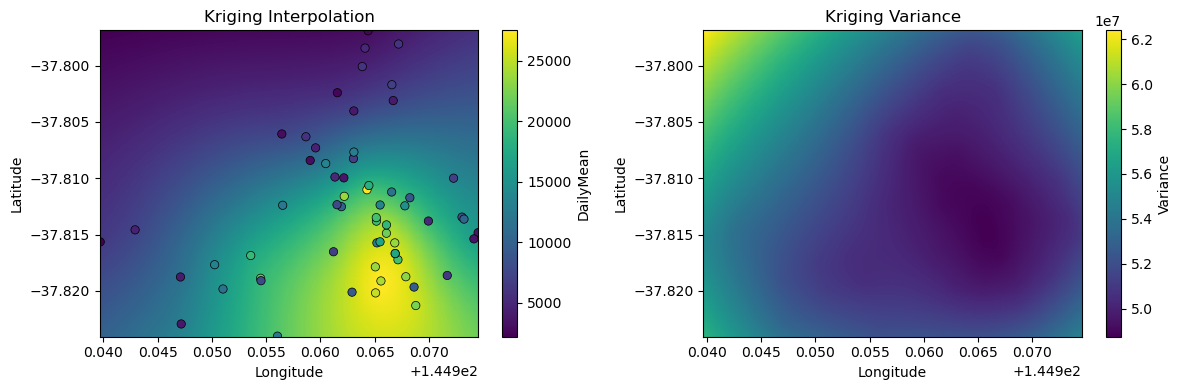

In [9]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Create the OrdinaryKriging object with three variables
ok = OrdinaryKriging(
    data['Longitude'],
    data['Latitude'],
    data['DailyMean'],
    variogram_model='linear',  # Choose the variogram model based on your analysis
    verbose=False,
    enable_plotting=False
)

# Perform kriging on the grid
z, ss = ok.execute('grid', grid_lon, grid_lat)

# Plot the kriged values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label='DailyMean')
plt.title('Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the kriged variance
plt.subplot(1, 2, 2)
plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
plt.colorbar(label='Variance')
plt.title('Kriging Variance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


### Ordinary Kriging with Cross Validation

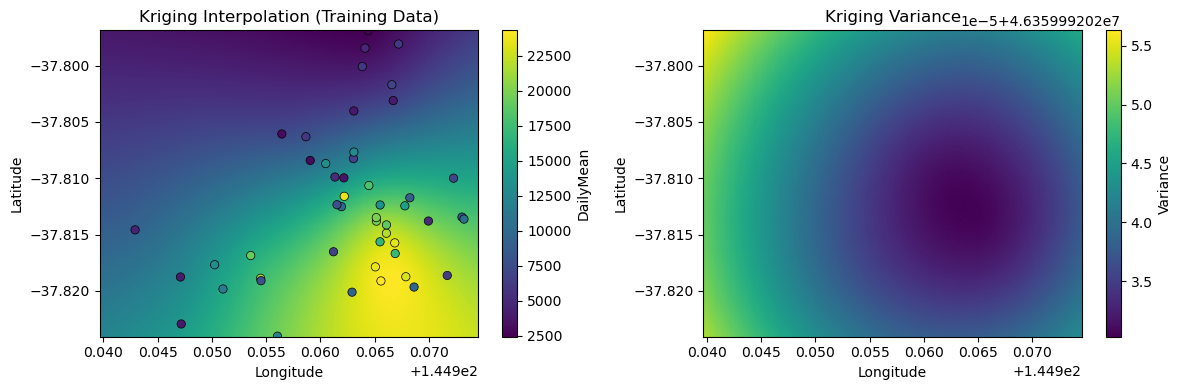

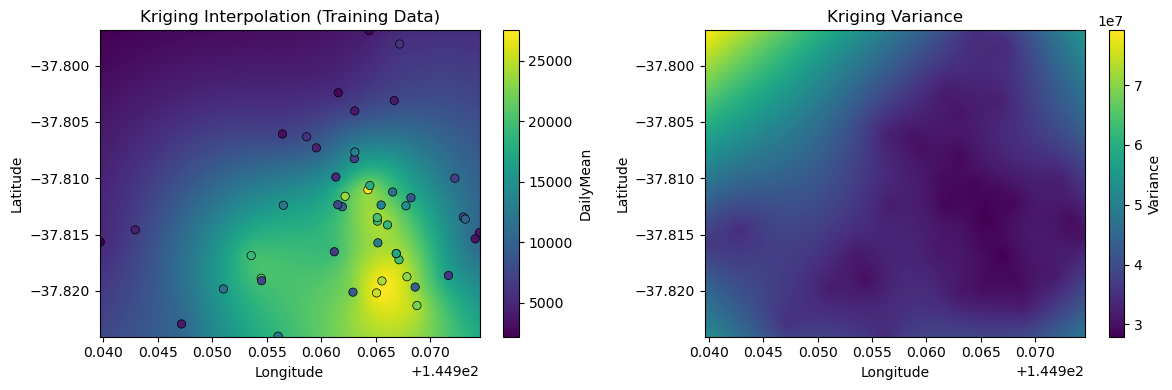

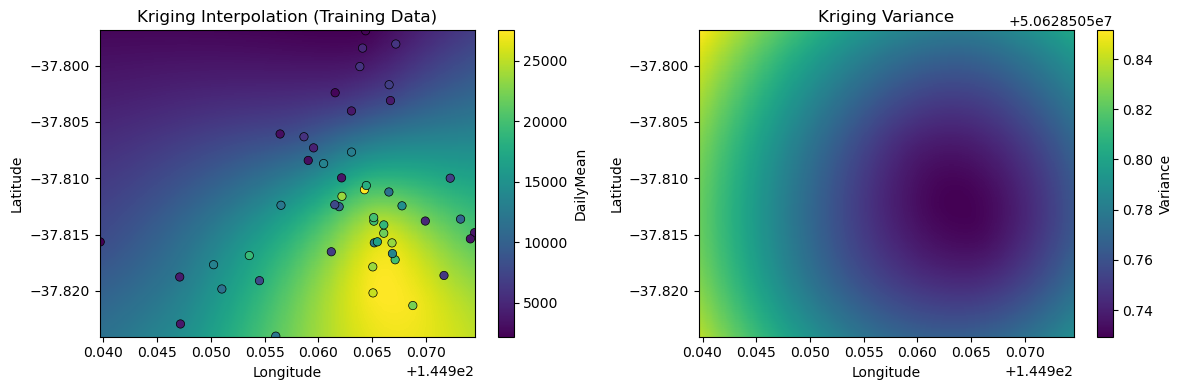

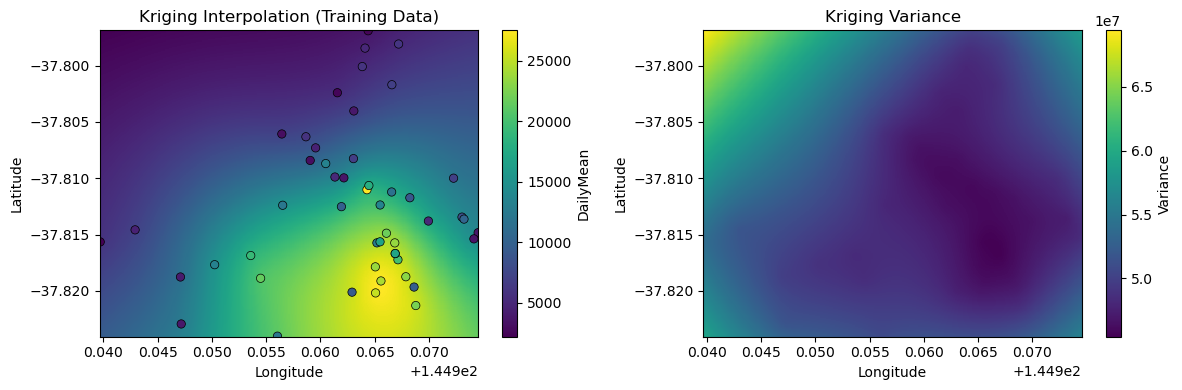

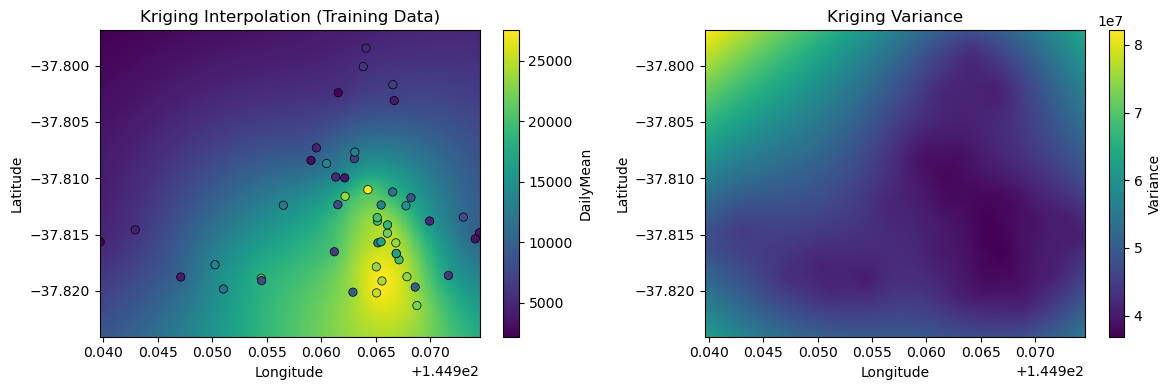

In [7]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# Perform kriging with cross-validation
for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Create the OrdinaryKriging object with three variables
    ok = OrdinaryKriging(
        train_data['Longitude'],
        train_data['Latitude'],
        train_data['DailyMean'],
        variogram_model='linear',  # Choose the variogram model based on your analysis
        verbose=False,
        enable_plotting=False
    )

    # Perform kriging on the grid
    z, ss = ok.execute('grid', grid_lon, grid_lat)

    # Plot the kriged values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
    plt.scatter(train_data['Longitude'], train_data['Latitude'], c=train_data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)
    plt.colorbar(label='DailyMean')
    plt.title('Kriging Interpolation (Training Data)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Plot the kriged variance
    plt.subplot(1, 2, 2)
    plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
    plt.colorbar(label='Variance')
    plt.title('Kriging Variance')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()


### Kriging with variables added, doesn't work with CV

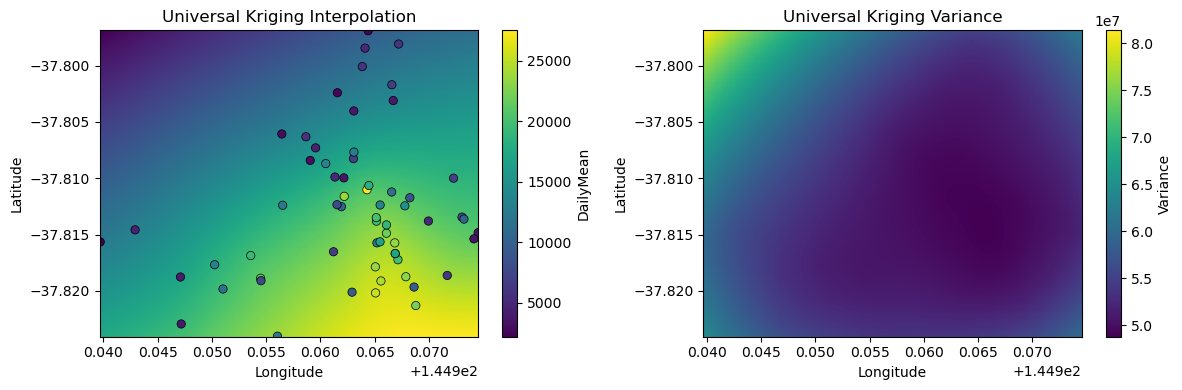

In [24]:
import numpy as np
import pandas as pd
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with columns: 'Longitude', 'Latitude', 'DailyMean', 'DistanceFromCentre'

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Create the UniversalKriging object with three variables
uk = UniversalKriging(
    data['Longitude'],
    data['Latitude'],
    data['DailyMean'],
    variogram_model='linear',  # Choose the variogram model based on your analysis
    # coordinates_type='geographic',
    drift_terms=['regional_linear', 'DistanceFromCentre'],  # Additional variable for drift
    verbose=False,
    enable_plotting=False
)

# Perform kriging on the grid
z, ss = uk.execute('grid', grid_lon, grid_lat)

# Plot the kriged values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label='DailyMean')
plt.title('Universal Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the kriged variance
plt.subplot(1, 2, 2)
plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
plt.colorbar(label='Variance')
plt.title('Universal Kriging Variance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

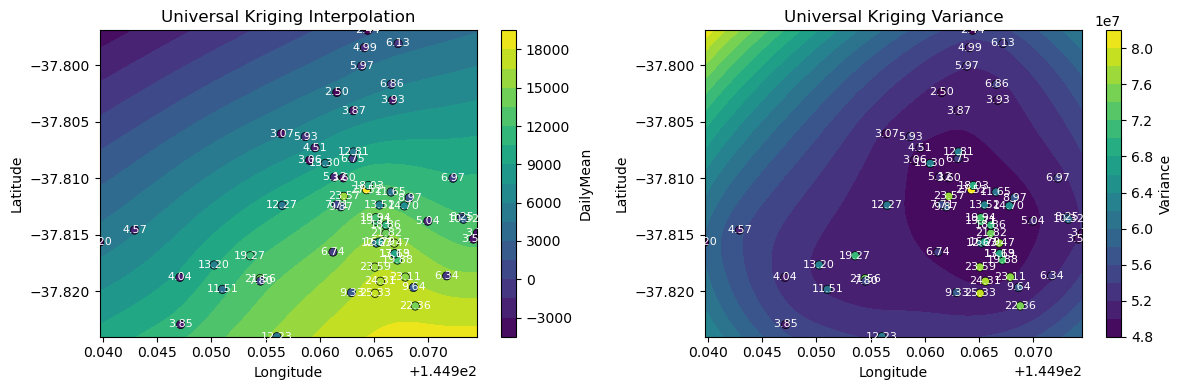

In [33]:
# Plot the kriged values using filled contours
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.contourf(grid_lon, grid_lat, z, cmap='viridis', levels=20)

# Add original data points with labels
for i, (lon, lat, daily_mean) in enumerate(zip(data['Longitude'], data['Latitude'], data['DailyMean'])):
    plt.text(lon, lat, f'{daily_mean:.2f}', color='white', ha='center', va='center', fontsize=8)

plt.colorbar(label='DailyMean')
plt.title('Universal Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add original data points
plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)

# Plot the kriged variance using filled contours
plt.subplot(1, 2, 2)
plt.contourf(grid_lon, grid_lat, ss, cmap='viridis', levels=20)

# Add original data points with labels
for i, (lon, lat, daily_mean) in enumerate(zip(data['Longitude'], data['Latitude'], data['DailyMean'])):
    plt.text(lon, lat, f'{daily_mean:.2f}', color='white', ha='center', va='center', fontsize=8)

plt.colorbar(label='Variance')
plt.title('Universal Kriging Variance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add original data points
plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)

plt.tight_layout()
plt.show()

### Universal Kriging

In [16]:
uk = UniversalKriging(
    data['Longitude'],
    data['Latitude'],
    data['DailyMean'],
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)
# Perform prediction on the grid
spatial_part, _ = uk.execute('grid', grid_lon, grid_lat)
# Linear Regression for trend part with three auxiliary variables
trend_data = data[['landmarks', 'betweenness']]
target = data['DailyMean'].values  # Ensure this is a numpy array

# Create the grid for trend part with the finer resolution
trend_grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
trend_grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Make a meshgrid for trend grid
trend_grid_lon, trend_grid_lat = np.meshgrid(trend_grid_lon, trend_grid_lat)

# Flatten the trend grid for prediction
trend_grid = np.column_stack((trend_grid_lon.flatten(), trend_grid_lat.flatten()))

# Perform prediction on the trend grid
reg = LinearRegression().fit(trend_data, target)
trend_part = reg.predict(trend_grid)

# Combine spatial and trend parts
z = spatial_part + trend_part.reshape(len(trend_grid_lon), len(trend_grid_lat))

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/kriging/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: cannot reshape array of size 94928 into shape (272,272)

In [11]:
import numpy as np
import pandas as pd
from pykrige.uk import UniversalKriging
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions with a finer resolution
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Universal Kriging for spatial part
coordinates = data[['Longitude', 'Latitude']].values
values = data['DailyMean'].values
uk = UniversalKriging(
    data['Longitude'],
    data['Latitude'],
    data['DailyMean'],
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

# Perform prediction on the grid
spatial_part, _ = uk.execute('grid', grid_lon, grid_lat)

# Linear Regression for trend part with three auxiliary variables
trend_data = data[['landmarks', 'betweenness']]
target = data['DailyMean'].values  # Ensure this is a numpy array

# Create the grid for trend part with the finer resolution
trend_grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
trend_grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Make a meshgrid for trend grid
trend_grid_lon, trend_grid_lat = np.meshgrid(trend_grid_lon, trend_grid_lat)

# Flatten the trend grid for prediction
trend_grid = np.column_stack((trend_grid_lon.flatten(), trend_grid_lat.flatten()))

# Perform prediction on the trend grid
reg = LinearRegression().fit(trend_data, target)
trend_part = reg.predict(trend_grid)

# Combine spatial and trend parts
z = spatial_part + trend_part.reshape(len(trend_grid_lat), len(trend_grid_lon))

# Plot the kriged values with the same scale for both subplots
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.pcolormesh(grid_lon, grid_lat, spatial_part, shading='auto')
plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label='DailyMean')
plt.title('Universal Kriging Interpolation (Spatial Part)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(data['Longitude'].min(), data['Longitude'].max())
plt.ylim(data['Latitude'].min(), data['Latitude'].max())

plt.subplot(1, 2, 2)
plt.pcolormesh(trend_grid_lon, trend_grid_lat, z, shading='auto')
plt.colorbar(label='DailyMean')
plt.title('Regression Universal Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(data['Longitude'].min(), data['Longitude'].max())
plt.ylim(data['Latitude'].min(), data['Latitude'].max())

plt.tight_layout()
plt.show()


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/kriging/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: cannot reshape array of size 94928 into shape (272,272)

### Different option to plot

In [ ]:
# Plot the kriged values with the same scale for both subplots
plt.figure(figsize=(12, 4))
fig, axs= plt.subplots(ncols=2, sharey=True, figsize = (12,4))

# plt.subplot(1, 2, 1)
im = axs[0].pcolormesh(grid_lon, grid_lat, spatial_part, shading='auto')
axs[0].scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)
# axs[0].colorbar(label='DailyMean')
axs[0].set_title('Kriging Interpolation (Spatial Part)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_xlim(data['Longitude'].min(), data['Longitude'].max())
axs[0].set_ylim(data['Latitude'].min(), data['Latitude'].max())

axs[1].pcolormesh(trend_grid_lon, trend_grid_lat, z, shading='auto')
# axs[1].set_colorbar(label='DailyMean')
axs[1].set_title('Regression Kriging Interpolation')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xlim(data['Longitude'].min(), data['Longitude'].max())
axs[1].set_ylim(data['Latitude'].min(), data['Latitude'].max())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.show()